In [16]:
import os, sys
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import cohen_kappa_score
import category_encoders as ce

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

from functools import partial
import scipy as sp              # for optimize.minimize()

In [17]:
# Execution environment setting
Kaggle = False

if Kaggle:
    DIR = '../input/data-science-bowl-2019'
    task_type = 'CPU'
else:
    DIR = 'data'
    task_type = 'GPU'

## Observe the data

In [18]:
train = pd.read_csv(os.path.join(DIR,'train.csv'))
train_labels = pd.read_csv(os.path.join(DIR,'train_labels.csv'))
specs = pd.read_csv(os.path.join(DIR,'specs.csv'))
test = pd.read_csv(os.path.join(DIR,'test.csv'))

In [19]:
print('train:\t\t',train.shape)
print('train_labels:\t',train_labels.shape)
print('specs:\t\t',specs.shape)
print('test:\t\t',test.shape)

train:		 (11341042, 11)
train_labels:	 (17690, 7)
specs:		 (386, 3)
test:		 (1156414, 11)


In [20]:
# make 'title' and 'event_code' list
title_list = list(set(train['title'].value_counts().index) \
                   .union(set(test['title'].value_counts().index)))
event_code_list = list(set(train['event_code'].value_counts().index) \
                   .union(set(test['event_code'].value_counts().index)))
print("title_list:\t\t",len(title_list))
print("event_code_list:\t\t",len(event_code_list))

title_list:		 44
event_code_list:		 42


In [21]:
# makes dict 'title to number(integer)'
title2num = dict(zip(title_list, np.arange(len(title_list))))
# makes dict 'number to title'
num2title = dict(zip(np.arange(len(title_list)), title_list))
# makes dict 'title to win event_code' 
# (4100 except 'Bird Measurer' and 4110 for 'Bird Measurer'))
title2win_code = dict(zip(title2num.values() \
                    ,(np.ones(len(title2num))).astype('int') * 4100))
title2win_code[title2num['Bird Measurer (Assessment)']] = 4110

In [22]:
# Convert 'title' to the number
train['title'] = train['title'].map(title2num)
test['title'] = test['title'].map(title2num)
train_labels['title'] = train_labels['title'].map(title2num)

# Convert 'timestamp' to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [23]:
# Convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    user_sample : DataFrame from train/test group by 'installation_id'
    test_set    : related with the labels processing
    '''
    # Constants and parameters declaration
    user_assessments = []
    last_type = 0
    types_count = {'Clip':0, 'Activity':0, 'Assessment':0, 'Game':0}
    time_first_activity = float(user_sample['timestamp'].values[0])
    time_spent_each_title = {title:0 for title in title_list}
    event_code_count = {code:0 for code in event_code_list}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    
    accumu_accuracy_group = 0
    accumu_accuracy=0
    accumu_win_n = 0 
    accumu_loss_n = 0 
    accumu_actions = 0
    counter = 0
    durations = []
    
    # group by 'game_session'
    for i, session in user_sample.groupby('game_session', sort=False):
        # i      : game_session_id
        # session: DataFrame from user_sample group by 'game_session'
        session_type = session['type'].iloc[0]  # Game/Assessment/Activity/Clip
        session_title = session['title'].iloc[0]
        
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)   # [sec]
            time_spent_each_title[num2title[session_title]] += time_spent
        
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100(4110)
            all_4100 = session.query(f'event_code == \
                                         {title2win_code[session_title]}')
            # numbers of wins and losses
            win_n = all_4100['event_data'].str.contains('true').sum()
            loss_n = all_4100['event_data'].str.contains('false').sum()

            # init features and then update
            features = types_count.copy()
            features.update(time_spent_each_title.copy())
            features.update(event_code_count.copy())
            features['session_title'] = session_title
            features['accumu_win_n'] = accumu_win_n
            features['accumu_loss_n'] = accumu_loss_n
            accumu_win_n += win_n
            accumu_loss_n += loss_n
            
            features['day_of_the_week'] = (session['timestamp'].iloc[-1]). \
                                            strftime('%A')    # Mod 2019-11-17

            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)

            # average of the all accuracy of this player
            features['accuracy_ave'] = accumu_accuracy / counter \
                                                if counter > 0 else 0
            accuracy = win_n / (win_n + loss_n) \
                                   if (win_n + loss_n) > 0 else 0
            accumu_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # average of accuracy_groups of this player
            features['accuracy_group_ave'] = \
                    accumu_accuracy_group / counter if counter > 0 else 0
            accumu_accuracy_group += features['accuracy_group']
            
            # how many actions the player has done in this game_session
            features['accumu_actions'] = accumu_actions
            
            # if test_set, all sessions belong to the final dataset
            # elif train, needs to be passed throught this clausule
            if test_set or (win_n + loss_n) > 0:
                user_assessments.append(features)
                
            counter += 1
        
        # how many actions was made in each event_code
        event_codes = Counter(session['event_code'])
        for key in event_codes.keys():
            event_code_count[key] += event_codes[key]

        # how many actions the player has done
        accumu_actions += len(session)
        if last_type != session_type:
            types_count[session_type] += 1
            last_type = session_type
            
    # if test_set, only the last assessment must be predicted,
    # the previous are scraped
    if test_set:
        return user_assessments[-1]
    return user_assessments

In [24]:
# get_data function is applyed to each installation_id
compiled_data = []
installation_n = train['installation_id'].nunique()
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby( \
                                     'installation_id', sort=False)),
                                     total=installation_n):
    # user_sample : DataFrame group by 'installation_id'
    compiled_data += get_data(user_sample)

C:\Users\Jie Huang\AppData\Local\Continuum\anaconda3\envs\pbskids\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



In [25]:
# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)
del compiled_data

In [26]:
# process test set, the same that was done with the train set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id',sort=False),
                                total=1000):
    new_test.append(get_data(user_sample, test_set=True))
    
new_test = pd.DataFrame(new_test)

C:\Users\Jie Huang\AppData\Local\Continuum\anaconda3\envs\pbskids\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



In [27]:
new_test.head(10)

,Clip,Activity,Assessment,Game,Tree Top City - Level 2,Pirate's Tale,Happy Camel,Tree Top City - Level 1,Bug Measurer (Activity),Egg Dropper (Activity),Bubble Bath,Bird Measurer (Assessment),Slop Problem,Leaf Leader,Chow Time,Cauldron Filler (Assessment),Scrub-A-Dub,Magma Peak - Level 2,Dino Drink,Crystal Caves - Level 3,Flower Waterer (Activity),Honey Cake,Air Show,Rulers,Sandcastle Builder (Activity),Crystal Caves - Level 2,Costume Box,Magma Peak - Level 1,Watering Hole (Activity),Crystal Caves - Level 1,"Heavy, Heavier, Heaviest",All Star Sorting,Welcome to Lost Lagoon!,Fireworks (Activity),Chest Sorter (Assessment),Lifting Heavy Things,Bottle Filler (Activity),Crystals Rule,Ordering Spheres,Mushroom Sorter (Assessment),Tree Top City - Level 3,Chicken Balancer (Activity),Treasure Map,Cart Balancer (Assessment),Dino Dive,12 Monkeys,Balancing Act,Pan Balance,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,accuracy_group,0,1,2,3,accuracy_group_ave,accumu_actions
0,5,3,1,3,0,0,0,0,33,88,0,0,0,0,135,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,1960,0,194,0,0,0,0,0,0,0,0,0,0,188,0,0,0,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,11,1,0,Thursday,30.000000,1.000000,0,0,0,0,1,3.000000,867
1,16,11,5,11,0,0,181,0,74,317,96,0,0,67,110,0,162,0,159,0,178,0,123,0,334,0,0,0,73,0,0,64,0,173,0,0,348,169,0,0,0,108,0,0,155,0,0,129,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,39,4,7,Wednesday,49.600000,0.466667,0,1,1,2,1,1.600000,2718
2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,35,0,0,Saturday,0.000000,0.000000,0,0,0,0,0,0.000000,149
3,4,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,77,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,35,0,0,Saturday,0.000000,0.000000,0,0,0,0,0,0.000000,233
4,5,1,0,4,0,0,155,0,0,0,0,0,0,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,610,0,0,0,0,0,0,0,0,0,221,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,39,0,0,Friday,0.000000,0.000000,0,0,0,0,0,0.000000,951
5,5,3,1,2,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,435,0,0,0,0,0,0,0,0,0,0,0,0,364,0,0,0,0,0,405,0,18,0,0,0,0,0,0,0,74,8,19,0,0,16,0,16,2,124,43,3,52,139,0,74,28,0,8,19,0,13,0,1,19,136,0,18,0,0,0,2,0,39,1,0,Sunday,27.000000,1.000000,0,0,0,0,1,3.000000,832
6,5,1,0,3,0,0,0,0,0,0,0,0,0,0,696,0,0,0,577,0,0,0,0,0,0,0,0,0,0,0,0,393,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,85,48,53,0,0,0,0,0,5,125,0,0,0,147,21,88,23,0,48,53,0,20,0,0,37,84,4,33,0,0,0,0,9,35,0,0,Tuesday,0.000000,0.000000,0,0,0,0,0,0.000000,887
7,12,8,8,7,0,0,88,0,82,175,0,0,0,83,127,0,20,0,0,0,212,0,141,0,52,0,0,0,20,0,0,88,0,182,0,0,291,0,0,0,0,143,0,0,0,0,0,0,0,12,3,1,0,3,2,1,1,240,12,29,0,0,0,0,0,7,272,9,44,50,369,0,244,61,22,12,30,2,42,0,7,43,227,2,35,0,2,1,0,0,7,7,2,Monday,34.555556,0.703704,0,2,1,0,6,2.111111,1785
8,4,3,2,5,0,0,0,0,139,0,143,0,0,0,213,0,309,0,0,0,0,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0,28,174,0,0,0,0,0,0,248,0,0,0,9,2,1,13,1,0,8,0,8,235,102,41,0,8,0,8,0,6,140,10,0,47,164,0,239,41,13,103,41,2,21,0,0,59,323,2,50,0,2,10,0,3,30,1,14,Saturday,52.000000,0.166667,0,2,0,1,0,0.666667,1712
9,2,0,0,1,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,16,0,0,1,1,0,0,0,0,0,0,0,39,0,0,Sunday,0.000000,0.000000,0,0,0,0,0,0.000000,23


In [28]:
# all_features but 'accuracy_group', that is the label y
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
# categorical feature
categorical_features = ['session_title','day_of_the_week']

In [29]:
# Encode categorical_features to integer(for use with LightGB,XGBoost,etc)

# concatnate train and test data
temp_df = pd.concat([new_train[all_features], new_test[all_features]])
# encode
encoder = ce.ordinal.OrdinalEncoder(cols = categorical_features)
temp_df = encoder.fit_transform(temp_df)
# dataset
X, y = temp_df.iloc[:len(new_train),:], new_train['accuracy_group']
X_test = temp_df.iloc[len(new_train):,:]

In [30]:
X.head()

,Clip,Activity,Assessment,Game,Tree Top City - Level 2,Pirate's Tale,Happy Camel,Tree Top City - Level 1,Bug Measurer (Activity),Egg Dropper (Activity),Bubble Bath,Bird Measurer (Assessment),Slop Problem,Leaf Leader,Chow Time,Cauldron Filler (Assessment),Scrub-A-Dub,Magma Peak - Level 2,Dino Drink,Crystal Caves - Level 3,Flower Waterer (Activity),Honey Cake,Air Show,Rulers,Sandcastle Builder (Activity),Crystal Caves - Level 2,Costume Box,Magma Peak - Level 1,Watering Hole (Activity),Crystal Caves - Level 1,"Heavy, Heavier, Heaviest",All Star Sorting,Welcome to Lost Lagoon!,Fireworks (Activity),Chest Sorter (Assessment),Lifting Heavy Things,Bottle Filler (Activity),Crystals Rule,Ordering Spheres,Mushroom Sorter (Assessment),Tree Top City - Level 3,Chicken Balancer (Activity),Treasure Map,Cart Balancer (Assessment),Dino Dive,12 Monkeys,Balancing Act,Pan Balance,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,0,1,2,3,accuracy_group_ave,accumu_actions
0,6,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,115,0,0,0,164,0,0,0,89,0,0,0,0,0,0,163,0,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,1,0,0,1,0.00,0.0,0,0,0,0,0.0,647
1,8,4,1,4,0,0,0,0,104,0,0,0,0,0,0,0,115,0,0,0,164,0,193,0,89,0,0,0,0,0,0,163,0,91,0,0,0,78,0,0,0,0,0,0,0,0,0,0,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,2,1,0,1,39.00,1.0,0,0,0,1,3.0,1143
2,8,4,2,4,0,0,0,0,104,0,0,0,0,0,0,0,115,0,0,0,164,0,193,0,89,0,0,0,0,0,0,163,0,91,0,0,0,78,0,0,0,0,0,0,0,0,0,0,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,1,1,11,1,65.50,0.5,1,0,0,1,1.5,1230
3,15,9,3,7,0,0,0,0,104,0,133,0,0,0,0,0,195,0,110,0,254,0,193,0,126,0,0,0,80,0,0,229,0,1611,0,0,165,78,0,0,0,0,0,0,0,0,0,0,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,1,2,11,1,41.25,0.5,2,0,0,2,1.5,2159
4,17,10,3,9,0,0,0,0,184,0,133,0,0,0,0,0,195,0,110,0,254,0,336,0,126,0,0,0,80,0,0,229,0,1611,0,0,165,310,0,0,0,0,0,0,0,0,0,0,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,2,3,12,1,39.20,0.5,2,0,1,2,1.6,2586


In [31]:
y.head()

0    3
1    0
2    3
3    2
4    3
Name: accuracy_group, dtype: int64

In [32]:
X_test.head()

,Clip,Activity,Assessment,Game,Tree Top City - Level 2,Pirate's Tale,Happy Camel,Tree Top City - Level 1,Bug Measurer (Activity),Egg Dropper (Activity),Bubble Bath,Bird Measurer (Assessment),Slop Problem,Leaf Leader,Chow Time,Cauldron Filler (Assessment),Scrub-A-Dub,Magma Peak - Level 2,Dino Drink,Crystal Caves - Level 3,Flower Waterer (Activity),Honey Cake,Air Show,Rulers,Sandcastle Builder (Activity),Crystal Caves - Level 2,Costume Box,Magma Peak - Level 1,Watering Hole (Activity),Crystal Caves - Level 1,"Heavy, Heavier, Heaviest",All Star Sorting,Welcome to Lost Lagoon!,Fireworks (Activity),Chest Sorter (Assessment),Lifting Heavy Things,Bottle Filler (Activity),Crystals Rule,Ordering Spheres,Mushroom Sorter (Assessment),Tree Top City - Level 3,Chicken Balancer (Activity),Treasure Map,Cart Balancer (Assessment),Dino Dive,12 Monkeys,Balancing Act,Pan Balance,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,0,1,2,3,accuracy_group_ave,accumu_actions
0,5,3,1,3,0,0,0,0,33,88,0,0,0,0,135,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,1960,0,194,0,0,0,0,0,0,0,0,0,0,188,0,0,0,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,3,1,0,4,30.0,1.000000,0,0,0,1,3.0,867
1,16,11,5,11,0,0,181,0,74,317,96,0,0,67,110,0,162,0,159,0,178,0,123,0,334,0,0,0,73,0,0,64,0,173,0,0,348,169,0,0,0,108,0,0,155,0,0,129,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,4,4,7,6,49.6,0.466667,1,1,2,1,1.6,2718
2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,1,0,0,2,0.0,0.000000,0,0,0,0,0.0,149
3,4,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,77,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,1,0,0,2,0.0,0.000000,0,0,0,0,0.0,233
4,5,1,0,4,0,0,155,0,0,0,0,0,0,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,610,0,0,0,0,0,0,0,0,0,221,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,4,0,0,5,0.0,0.000000,0,0,0,0,0.0,951


In [33]:
del train,test

## Step 1 : Create Regressor Models
Create multiple train_datasets using `kFold` and create a regression model from each dataset. I used ** CatBoost **, ** XGBoost **, ** LightGBM **.

In [34]:
# Create multiple datasets to create multiple models (not for CV).
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

### - CatBoost

In [35]:
# makes the model and set the parameters
def make_CatBoost(task_type):
    model = CatBoostRegressor(
        iterations=5000,
        learning_rate=0.02,
        loss_function='RMSE',
        random_seed=42,
        depth=10,                            # add
        border_count=108,                    # add
        bagging_temperature=2.348502,        # add
        task_type=task_type,
        early_stopping_rounds=200
    )
    return model

In [36]:
# CatBoost
start_time = time()
cat_models = []
scores = []

# Train and make models
for fold, (train_ids, test_ids) in enumerate(folds.split(X, y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    model = make_CatBoost(task_type)
    model.fit(X.loc[train_ids, all_features], y.loc[train_ids], 
              eval_set=(X.loc[test_ids, all_features], y.loc[test_ids]),
              use_best_model=False,
              verbose=500,
              cat_features=categorical_features)    
    cat_models.append(model)
    
print('Time:', time() - start_time)

● Fold : 1 / 5
0:	learn: 1.2493400	test: 1.2498009	best: 1.2498009 (0)	total: 468ms	remaining: 39m 1s
500:	learn: 0.9521633	test: 1.0139668	best: 1.0139668 (500)	total: 3m 31s	remaining: 31m 38s
1000:	learn: 0.9223432	test: 1.0090593	best: 1.0090593 (1000)	total: 6m 54s	remaining: 27m 34s
1500:	learn: 0.9035042	test: 1.0071239	best: 1.0070928 (1479)	total: 10m 12s	remaining: 23m 48s
2000:	learn: 0.8903834	test: 1.0068302	best: 1.0067996 (1993)	total: 13m 22s	remaining: 20m 2s
bestTest = 1.006781751
bestIteration = 2014
● Fold : 2 / 5
0:	learn: 1.2491276	test: 1.2492092	best: 1.2492092 (0)	total: 424ms	remaining: 35m 19s
500:	learn: 0.9524734	test: 0.9998413	best: 0.9998350 (498)	total: 3m 31s	remaining: 31m 40s
1000:	learn: 0.9227993	test: 0.9952840	best: 0.9952840 (1000)	total: 6m 59s	remaining: 27m 57s
1500:	learn: 0.9036994	test: 0.9937334	best: 0.9937334 (1500)	total: 10m 26s	remaining: 24m 19s
2000:	learn: 0.8876589	test: 0.9927769	best: 0.9926942 (1970)	total: 13m 52s	remaining: 

### -XGBoost

In [37]:
# XGBoost
start_time = time()
xgb_models = []
scores = []

params = {
    'max_depth': 9,                 # 6           # mod 10→9
    'learning_rate': 0.01,          # = eta 0.1: [0,1]
    'objective': 'reg:linear',                    # add
    'n_estimators' : 300,           # 100
    'subsample': 0.6,               # 1, (0,1]    # mod 0.8→0.6
    'colsample_bytree': 1.0,        # 1, (0, 1]   # mod 0.8→1.0
    'gamma': 0.0,                                 # add
    'min_child_weight': 5,                        # add
    'seed' : 42,
}

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    dtrain = xgb.DMatrix(X.iloc[train_ids], y[train_ids])
    dval = xgb.DMatrix(X.iloc[val_ids], y[val_ids])
    model = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=5000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=100,
                      verbose_eval=100
                     )
    xgb_models.append(model)
    
print('Time:', time() - start_time)

● Fold : 1 / 5
[11:44:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.857	val-rmse:1.8576
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
C:\Users\Jie Huang\AppData\Local\Continuum\anaconda3\envs\pbskids\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[100]	train-rmse:1.07814	val-rmse:1.16462
[200]	train-rmse:0.856879	val-rmse:1.03142
[300]	train-rmse:0.777816	val-rmse:1.0093
[400]	train-rmse:0.732928	val-rmse:1.00476
[500]	train-rmse:0.699094	val-rmse:1.00325
[600]	train-rmse:0.669988	val-rmse:1.00339
Stopping. Best iteration:
[527]	train-rmse:0.691202	val-rmse:1.00311

● Fold : 2 / 5
[11:44:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederr

### - LightGBM

In [38]:
# LightGBM
start_time = time()
lgb_models = []
scores = []

params = {
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'regression',
#     'num_iteration': 100,           # add
    'metric': 'rmse',
    'eval_metric': 'cappa',
    'subsample': 0.75,
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→
    'bagging_freq': 1,              # add
    'colsample_bytree': 0.8,        # add
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'max_depth': 13,                # mod 10→
    'num_leaves': 1028,             # mod      # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
}

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    train_set = lgb.Dataset(X.iloc[train_ids], y[train_ids],
                           categorical_feature=categorical_features)
    val_set = lgb.Dataset(X.iloc[val_ids], y[val_ids],
                         categorical_feature=categorical_features)
    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=[train_set, val_set],
                      num_boost_round=5000,
                      early_stopping_rounds=100,    # del
                      verbose_eval=200
                     )
    lgb_models.append(model)
    
print('\nTime:', time() - start_time)

● Fold : 1 / 5
C:\Users\Jie Huang\AppData\Local\Continuum\anaconda3\envs\pbskids\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.649737	valid_1's rmse: 1.01214
Early stopping, best iteration is:
[190]	training's rmse: 0.659306	valid_1's rmse: 1.01198
● Fold : 2 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.658803	valid_1's rmse: 0.996041
Early stopping, best iteration is:
[217]	training's rmse: 0.643271	valid_1's rmse: 0.995459
● Fold : 3 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.658103	valid_1's rmse: 1.00486
Early stopping, best iteration is:
[256]	training's rmse: 0.613827	valid_1's rmse: 1.00419
● Fold : 4 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.658733	v

## Step 2 : Predict each Model

In [39]:
preds = []

# CatBoost models
for model in cat_models:
    pred = model.predict(X)
    preds.append(pred)
    
# XGBoost models
for model in xgb_models:
    pred = model.predict(xgb.DMatrix(X))
    pred = pred.flatten()
    preds.append(pred)
    
# LightGBM models
for model in lgb_models:
    pred = model.predict(X,num_iteration=model.best_iteration)
    pred = pred.reshape(len(X),1).flatten()
    preds.append(pred)

df = pd.DataFrame(preds).T
df.columns = ['C1','C2','C3','C4','C5',   # CatBoost
              'X1','X2','X3','X4','X5',   # XGBoost
              'L1','L2','L3','L4','L5']   # LightGBM

In [40]:
# Calculate the average value of each model pred
df['mean'] = df.mean(axis = 'columns')
df.head(10)

,C1,C2,C3,C4,C5,X1,X2,X3,X4,X5,L1,L2,L3,L4,L5,mean
0,2.075557,2.176982,2.122030,2.085767,2.197312,2.363882,2.434636,2.390255,2.413634,2.463508,2.419634,2.340672,2.452753,2.558339,2.576658,2.338108
1,1.794419,1.665245,1.771294,1.836976,1.804048,1.581564,1.213217,1.409691,1.918423,1.665534,1.004882,0.838792,0.937059,1.679223,1.154034,1.484960
2,2.437763,2.207402,2.296176,2.293965,2.341893,2.615989,2.288051,2.407741,2.536719,2.522454,2.580365,2.286519,2.420137,2.450166,2.446271,2.408774
3,2.339340,2.056566,2.229772,2.258846,2.189489,2.396954,2.209756,2.163733,2.323062,2.182261,2.117693,1.952230,2.165918,2.133641,1.972361,2.179442
4,1.369923,0.993352,1.309290,1.285641,1.279830,1.913056,1.339200,1.873231,1.837268,1.582159,2.029291,1.204169,2.141200,1.956980,1.921781,1.602425
5,1.943348,2.102798,2.035377,2.068776,2.114349,2.330796,2.417998,2.450551,2.285724,2.099069,2.384782,2.619510,2.607608,2.457652,2.122598,2.269396
6,1.993537,1.948162,1.988350,2.162274,1.890393,1.193763,1.260469,1.206772,2.197736,1.016792,1.189743,0.978386,0.933794,1.931606,1.041011,1.528853
7,0.808346,0.699197,0.855887,0.952693,0.780168,1.398646,1.219092,1.346124,1.333897,0.768915,1.533562,1.406443,1.356612,1.473476,0.968410,1.126765
8,1.317580,1.501738,1.615040,1.523887,1.767556,1.358021,1.847490,2.090685,1.965692,2.156619,1.295292,1.519800,1.926270,1.804742,1.933070,1.708232
9,1.959041,1.946912,1.945602,1.887777,1.830427,1.995329,1.936194,1.990999,1.832477,1.957125,1.866028,1.984921,2.010183,1.956421,1.877032,1.931765


## Step 3 : Optimize Rounding Coefficients
The rounding coefficient is optimized using the average value of the prediction results of each model. Optimization uses `scipy.optimize.minimize()`.

In [41]:
class OptRounder(object):
    def __init__(self):
        self.res_ = []
        self.coef_ = []
        
    def get_res(self):
        return self.res_
    
    # objective function
    def func(self, coef, X, y):
        kappa = cohen_kappa_score(self.bincut(coef, X), y, weights='quadratic')
        return -kappa

    def bincut(self, coef, X):
        return pd.cut(X,
                      [-np.inf] + list(np.sort(coef)) + [np.inf],
                      labels = [0, 1, 2, 3])
        
    def fit(self, X, y):
        pfunc = partial(self.func, X=X, y=y)
        self.res_ = sp.optimize.minimize(fun = pfunc,           # objective function
                                         x0 = [0.6, 1.5, 2.4],  # initial coefficients
                                         method='nelder-mead')  # solver
        self.coef_ = self.res_.x
        
    def predict(self, X, coef):
        return self.bincut(coef, X)

In [42]:
optR = OptRounder()
optR.fit(df['mean'].values.reshape(-1,), y)
res = optR.get_res()        # Optimized result

print('●Iterations performed\t:',res.nit)
print('●Optimized coefficients\t:',res.x)
print('●Cohen Kappa score\t:',-res.fun)

coefficients = res.x        # Optimized coefficients

●Iterations performed	: 53
●Optimized coefficients	: [1.12646207 1.67386629 2.23061993]
●Cohen Kappa score	: 0.7913785064060251


## Step 4 : Final Classification

In [43]:
# final classification
df['predict'] = optR.predict(df['mean'].values, coefficients).astype(int)

df['y'] = y
df[['mean','predict','y']].head(10)

,mean,predict,y
0,2.338108,3,3
1,1.484960,1,0
2,2.408774,3,3
3,2.179442,2,2
4,1.602425,1,3
5,2.269396,3,3
6,1.528853,1,0
7,1.126765,1,2
8,1.708232,2,3
9,1.931765,2,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ECB2EDED88>,
      dtype=object)

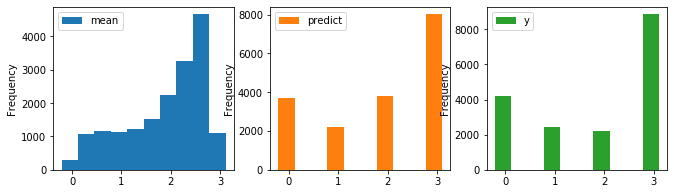

In [44]:
df[['mean','predict','y']].plot(subplots=True,layout=(1, 3),figsize=(11, 3),kind='hist')

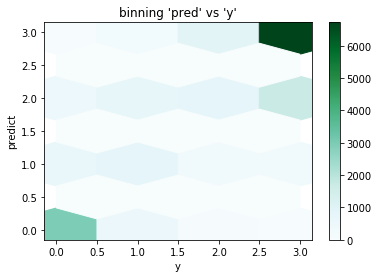

In [45]:
# binning plot of 'pred' versus 'y'
df.plot.hexbin(x='y', y='predict', gridsize=(3,3), sharex=False, title = "binning 'pred' vs 'y'")

## Make submission

In [46]:
preds = []
for model in cat_models:        # CatBoost
    pred = model.predict(X_test)
    preds.append(pred)
for model in xgb_models:        # XGBoost
    pred = model.predict(xgb.DMatrix(X_test))
    pred = pred.flatten()
    preds.append(pred)
for model in lgb_models:        # LightGBM
    pred = model.predict(X_test,num_iteration=model.best_iteration)
    pred = pred.reshape(len(X_test),1).flatten()
    preds.append(pred)
df_s = pd.DataFrame(preds).T

df_s['mean'] = df_s.mean(axis = 'columns')

# Classification
df_s['pred'] = optR.predict(df_s['mean'].values, coefficients).astype(int)

print(df_s.shape)
df_s[['mean','pred']].head(10)

(1000, 17)


,mean,pred
0,2.224293,2
1,2.861152,3
2,2.628783,3
3,2.519241,3
4,2.426642,3
5,2.653035,3
6,2.028872,2
7,2.105818,2
8,0.236973,0
9,1.790449,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC30F88348>,
      dtype=object)

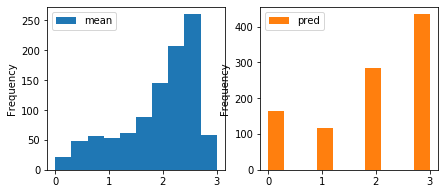

In [47]:
df_s[['mean','pred']].plot(subplots=True, layout=(1, 2), figsize=(7, 3), kind='hist')

In [48]:
submission = pd.read_csv(os.path.join(DIR,'sample_submission.csv'))
submission['accuracy_group'] = df_s['pred']
submission.head(10)

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
5,02256298,3
6,0267757a,2
7,027e7ce5,2
8,02a29f99,0
9,0300c576,2


In [49]:
submission.to_csv('submission.csv', index=None)